# Air Quality in Vienna - By Simon Groß

https://aqicn.org/api/ provides Data regarding the Air Quality Index on station level around the world. This notebook aims to collect data, infer different parameters around the stations and use weather data to create a model that can be used to forecast air quality on the stations and create an air quality hexagonal grid for vienna.

Also it will be tested if the model can be applied to other cities.

# Applications Domain


Through rising urbanization, urban population is growing around the world. Dense living, lack of green spaces, traffic and many other factors influence air quality in these urban environments. First action plans to combat the deteriorating conditions of urban air quality are introduced (Gulia et al. 2015) and the calm months of strict covid lockdowns showed that air quality can be better (Cioca et al. 2022). For Vienna, models and projections for air quality exist, where multiple data sources are combined, and projections are given on a detailed level (Kurz et al. 2014). 

A simpler approach is taken in this analysis. To analyze air quality, data is needed. Aqicn.org provides a united global framework for measuring air quality. The data is publicly available and can thus be used to create a model. However, the density of these stations is not enough to cover a whole city. Therefore, predictive variables are not only inferred for the stations, but also on a grid of virtual stations covering Vienna, that can then be displayed in a hexagonal pattern. Predictive Variables are land use classes and weather data.



# Objective and Questions

This study aims to build a model, that reliably predicts air quality on a spatial raster in Vienna, to provide a complete prediction for the whole city based on land use and climate data. This model can be used to answer, where in Vienna we have good and bad air quality spots.

The research question is as follow: How is the air quality in vienna and by which variables is it influenced?

### Imports and set variables

First import all needed modules

In [1]:
import os
import copy
import pickle
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from random import sample
import matplotlib.pyplot as plt
from datetime import datetime as dt
from scipy.spatial import Voronoi, voronoi_plot_2d

from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.ops import nearest_points

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

Set API-Token for air quality data. Please do not abuse this token :)

In [2]:
token = '...'

# Study Area
The study area is Vienna. We load in a shapefile, reproject it, extract the bounding box and set a start and end date for the data acquisition period. A buffer is also created to eliminate small mistakes in the shapefiles geometry.

The timeframe was chosen in order to have the most recent full year of data. This timefame could be extended at will, however the API requests have to be sent anew.

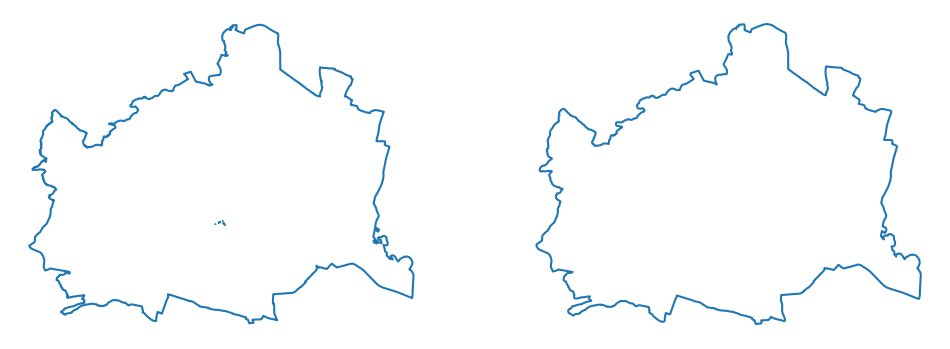

In [3]:
# Get Vienna bounds
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
vienna = gpd.read_file("../data/vienna.shp")
vienna.dissolve().boundary.plot(ax=axs[0])
axs[0].axis('off')

vienna['geometry'] = vienna['geometry'].apply(lambda x: x.buffer(0.001))
vienna = vienna.dissolve()
vienna.boundary.plot(ax=axs[1])
vienna_rep = vienna.to_crs(32633)
axs[1].axis('off')


# Get the bound coordinates as string
bounds = vienna.bounds.values[0].tolist()
st = str(bounds[1]) + ',' + str(bounds[0]) + ',' + str(bounds[3]) + ',' + str(bounds[2])

start_date = '2022-01-01'
end_date = '2022-12-31'
analysis_date = "2023-05-01"

Small mistakes in the geometry are still visible in the first file and are eliminated through buffering the geometries before dissolving.

### Make API requests
Send an API request to the air quality data website and get all stations withing the bounding box of vienna. Save these in a dataframe and create a geodataframe with the latitude and longitude. Create the request only one time and save it afterwards to avoid changes in the API.

In [4]:
# Create request string and send request
# req = f"https://api.waqi.info/v2/map/bounds?latlng={st}&networks=all&token={token}"
# response_air = requests.get(req).json()

# with open("../data/response_air.pkl", "wb") as fp:
#     pickle.dump(response_air, fp)

In [5]:
with open("../data/response_air.pkl", "rb") as fp:
    response_air = pickle.load(fp)

In [6]:
df_air = pd.DataFrame(response_air['data'])
df_air['name'] = df_air.station.apply(lambda x: x['name']).values.tolist()
df_air = df_air.rename(columns={'aqi': 'current_response_aqi'})

gdf_air = gpd.GeoDataFrame(df_air, geometry=gpd.points_from_xy(df_air.lon, df_air.lat), crs=4326)
gdf_air.head()

,lat,lon,uid,current_response_aqi,station,name,geometry
0,48.216739,16.380918,2860,46,"{'name': 'Ecke Taborstraße - Glockengasse, Aus...","Ecke Taborstraße - Glockengasse, Austria",POINT (16.38092 48.21674)
1,48.261086,16.396954,4738,46,"{'name': 'Floridsdorf, Gerichtsgasse 1a (Prage...","Floridsdorf, Gerichtsgasse 1a (Prager Str. 65m...",POINT (16.39695 48.26109)
2,48.205000,16.309750,2850,46,"{'name': 'Kendlerstraße 40 (Umspannwerk), Aust...","Kendlerstraße 40 (Umspannwerk), Austria",POINT (16.30975 48.20500)
3,48.145000,16.474444,2836,46,"{'name': 'Radetzkystraße, Phönix-Sportplatz, M...","Radetzkystraße, Phönix-Sportplatz, Mühlgasse, ...",POINT (16.47444 48.14500)
4,48.226361,16.458345,2855,55,"{'name': '1, Hausgrundweg 23, Gstr. 254, Austr...","1, Hausgrundweg 23, Gstr. 254, Austria",POINT (16.45835 48.22636)


### Get Historical Air Quality Data
Since the API only gives us the current values we need to get historical data. These have to be downloaded manually from the website by giving the names of the stations.

In [7]:
names = df_air.station.apply(lambda x: x['name']).values.tolist()
names

['Ecke Taborstraße - Glockengasse, Austria',
 'Floridsdorf, Gerichtsgasse 1a (Prager Str. 65m), Austria',
 'Kendlerstraße 40 (Umspannwerk), Austria',
 'Radetzkystraße, Phönix-Sportplatz, Mühlgasse, Austria',
 '1, Hausgrundweg 23, Gstr. 254, Austria',
 'Allgemeines Krankenhaus, Ostringweg (zwischen Gebäuden BT25), Austria',
 'Umspannwerk Gaudenzdorfer Gürtel, Austria',
 '4, Schafbergbad, Josef Redl Gasse 2, Gstr.Nr. 698, Austria',
 'Lobau Grundwasserwerk, Austria',
 'Laaer Berg, Theodor Sickel-Gasse 1, Austria',
 'Danubiastraße, Brücke A4, Austria',
 'Kaiserebersdorf, Alberner Straße 8 (Umspannwerk) (A4 160m), Austria',
 '11, KG Erlaa), Carlberger-Gasse 69 (Gst. Nr. 273, Austria',
 '252, Belgradplatz (Südostecke), Gstr.Nr. 816, Austria',
 '250, Wehlistraße 366, Gstr.Nr.2157, Austria',
 'Parkplatz Bahnhof Klosterneuburg-Kierling, Austria']

### Manually Download csvs
https://aqicn.org/data-platform/register/ <-- on this website we put in the names form above and download the csvs

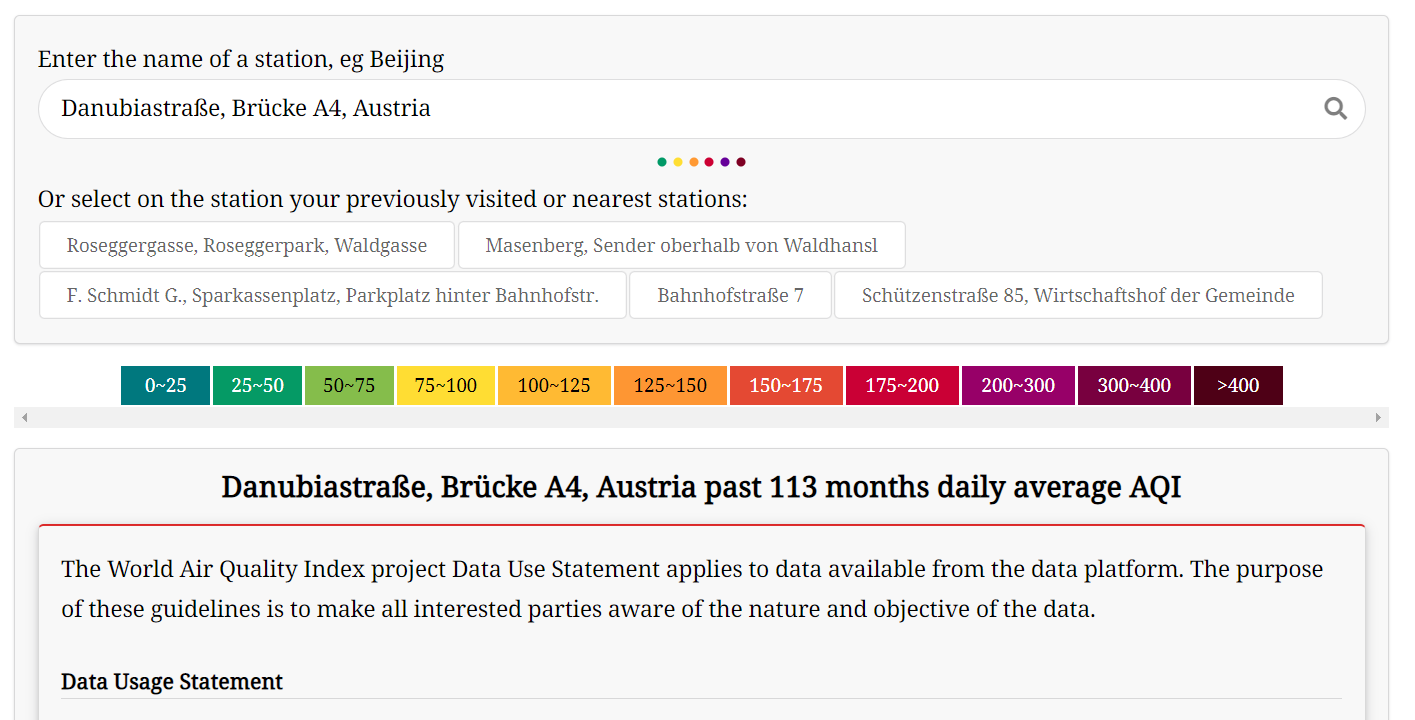

(16.16094714209118, 16.598398279065602, 48.10656521294201, 48.3340046826541)

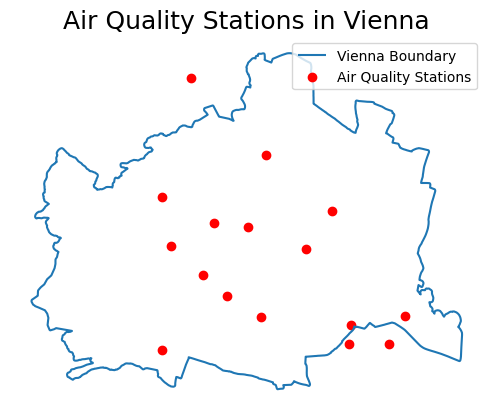

In [8]:
fig, ax = plt.subplots(1)
vienna.boundary.plot(ax=ax)
gdf_air.plot(ax=ax, color='red')
_ = ax.set_title('Air Quality Stations in Vienna', size=18)
ax.legend(['Vienna Boundary', 'Air Quality Stations'])
ax.axis('off')

Here are the air quality stations in and around vienna. Some of them are not inside the boundary, however this is not important since having a buffer around vienna is nothing bad for this analysis and helps to calculate the grid later more accurately. However, there won't be any landuse values for these areas since the Land Niederösterreich does not provide this data. This is a flaw in the model that is acknowledged here.

### Load Historical Air Quality Data
Each csv is downloaded and saved in the folder ../data/airqualiy. Each csv is then loaded. The date is casted to a datetime format, then the only the data between the start and end of the study period is extracted. The AQI (Air Quality Index) is then calculated via the formular in the [website](https://aqicn.org/data-platform/register/). All csvs are saved in a dictionary with the first 10 letters of the name as key.

In [9]:
%%capture output
# Load in and use first 10 letters to identify station
csvs = sorted(os.listdir('../data/airquality'))
airquality_csvs = {}
for csv in csvs:
    
    df = pd.read_csv(f'../data/airquality/{csv}')

    df['date'] = pd.to_datetime(df.date)
    df = df.set_index('date')
    
    df = df.apply(lambda x: x.astype(float))
    df = df.loc[start_date:end_date]

    # Take the maximum (like said on website)
    df['AQI'] = df.max(axis=1)
    
    
    airquality_csvs[csv[:10].replace(" ", "-")] = df    

In [10]:
airquality_csvs.keys()

dict_keys(['1,-hausgru', '11,-kg-erl', '250,-wehli', '252,-belgr', '4,-schafbe', 'allgemeine', 'danubiastr', 'ecke-tabor', 'floridsdor', 'kaisereber', 'kendlerstr', 'laaer-berg', 'lobau-grun', 'parkplatz-', 'radetzkyst', 'umspannwer'])

The first 10 letters are also used for the air quality metadata. Via this key, the historical data ist attached to the metdata, containing the geoinformation. This dataframe is also reprojected in EPSG:32633

In [11]:
# Use first 10 letters for the air quality metadata as well
gdf_air['name10'] = gdf_air['name'].apply(lambda x: x[:10].lower().replace(" ", "-"))
gdf_air = gdf_air.sort_values('name10').reset_index().drop(columns=['index'])
gdf_air['data'] = airquality_csvs.values()

def set_index(df):
    df.index = df.index.astype(str)
    return df

gdf_air['data'] = gdf_air['data'].apply(set_index)

gdf_air_rep = gdf_air.to_crs(32633)

# EDA: Distribution of Air Quality Values

In [12]:
vals = gdf_air.apply(lambda x: x['data']['AQI'], axis=1).values.flatten()

Text(0.5, 1.0, 'Distribution of AQI Measurements')

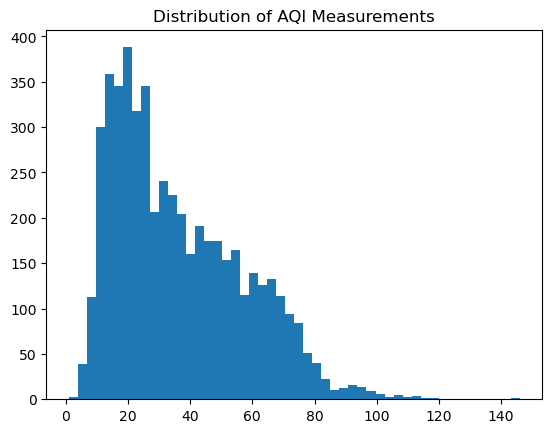

In [13]:
fig, ax = plt.subplots(1)
_ = ax.hist(vals, bins=50)
ax.set_title('Distribution of AQI Measurements')

The AQI measurements are distributed with a left leaning distrubution of values. Most values lie between 15 and 25. These are considered good AQI values. The higher the values, the lower the air quality. There are however als values with worse air quality.

# Distribution over Time

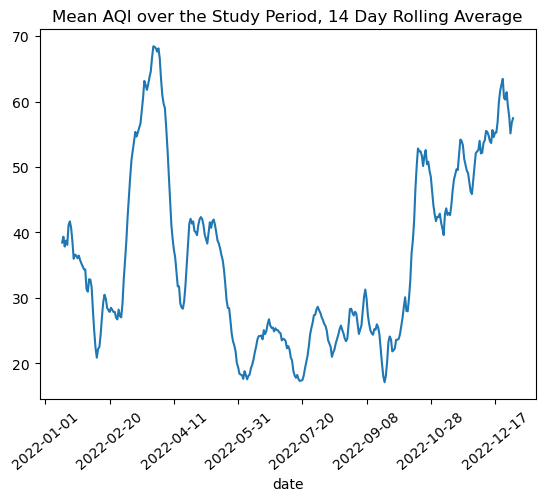

In [14]:
fig, ax = plt.subplots(1)
gdf_air.apply(lambda x: x['data']['AQI'], axis=1).mean().rolling(14).mean().plot(ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=40)
_ = ax.set_title('Mean AQI over the Study Period, 14 Day Rolling Average')

The mean over all stations over time shows, that the AQI varies greatly during the study period. Since it seems to be changing with the seasons. Using weather data could be a good indicator for air quality.

# Landuse Data
Landuse data is downloaded from the [Austrian OGD Platform](https://www.data.gv.at/katalog/de/dataset/stadt-wien_realnutzungskartierungab200708wien#resources), specifically the dataset WFS GetFeature (SHP) - 2020. This shape is dissolved by the NUTZUNG_L0 column, since that gives a good balance between amount of data and details. Finally it is reprojected as well into 32633.

This is only done once and the file is saved and loaded for the other times since it takes a while. For testing uncomment the cell below.

In [15]:
# Dissolve by the most detailed landuse class

# LONG LOADING, LOAD BELOW
# landuse = gpd.read_file("../data/landuse.shp")
# landuse_diss = landuse.dissolve(by='NUTZUNG_L0')

# landuse_diss_rep = landuse_diss.to_crs(32633)
# landuse_diss_rep.to_file("../data/landuse_diss_repr.shp")

In [16]:
landuse_diss_rep = gpd.read_file("../data/landuse_diss_repr_fixed.shp")
classes_landuse = landuse_diss_rep.NUTZUNG_L0.values.tolist()
classes_landuse.remove('Straßenraum')
classes_landuse_og = copy.deepcopy(classes_landuse)

Text(0.5, 1.2, 'Landuse Percentages for Vienna')

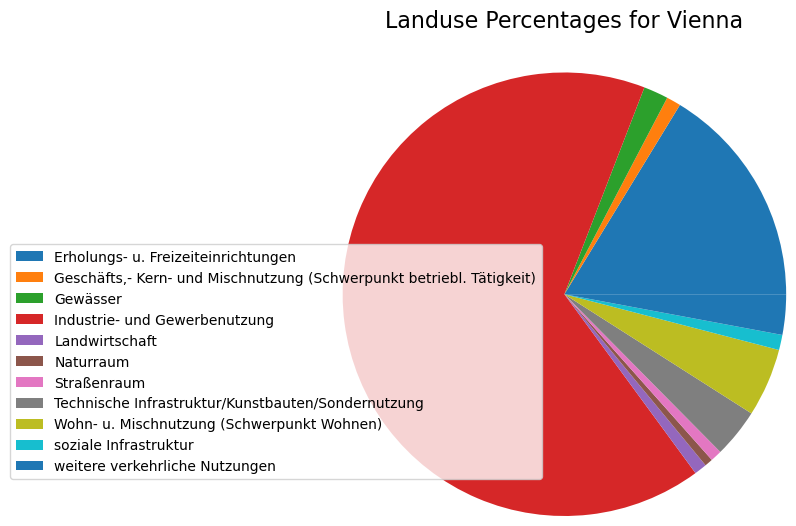

In [17]:
fig, ax = plt.subplots(1)
stats = landuse_diss_rep.groupby('NUTZUNG_L0').FLAECHE.sum()

labs = stats.index

patches, texts = plt.pie(stats.values, radius=1.5)
plt.legend(patches, labs, loc=(-1,0))
ax.set_title("Landuse Percentages for Vienna", y=1.2, size=16)

The landuse classes are distributed unevenly. Main areas are industrial & commercial (red), leisure areas (bigger blue) and residential and mixed use (yellow).

### Get Landuse Percentages
In order to assiciate landuse with the air quality measurements. A buffer was calculated for each station in the dataset. This buffer then clips a part form the landuse layer and divides the area of each landuse class by the area of the buffer. These are the landuse percentages. Since the landuses are assumend to be stationary over the data period, this data only differs from station to station but not temporarily.

In [18]:
stations_percentages = {}

def clipping(station):
    station_id = station.name
    stations_percentages[station_id] = {key: 0 for key in classes_landuse_og}
    
    buffer = station.geometry.buffer(100) 
    clipped = gpd.clip(landuse_diss_rep, buffer)
    
    areas = clipped.geometry.area.tolist()
    total_area = buffer.area
    
    for i, cls in enumerate(clipped.NUTZUNG_L0.tolist()):
        # Filter Streets as it does not work well/has problems in the data
        if cls == 'Straßenraum':
            continue
        stations_percentages[station_id][cls] = areas[i] / total_area
        
_ = gdf_air_rep.apply(clipping, axis=1)

perc = pd.DataFrame(stations_percentages).T.fillna(0)
gdf_air_rep[perc.columns] = perc
gdf_air_rep.head(3)

,lat,lon,uid,current_response_aqi,station,name,geometry,name10,data,Erholungs- u. Freizeiteinrichtungen,"Geschäfts,- Kern- und Mischnutzung (Schwerpunkt betriebl. Tätigkeit)",Gewässer,Industrie- und Gewerbenutzung,Landwirtschaft,Naturraum,Technische Infrastruktur/Kunstbauten/Sondernutzung,Wohn- u. Mischnutzung (Schwerpunkt Wohnen),soziale Infrastruktur,weitere verkehrliche Nutzungen
0,48.226361,16.458345,2855,55,"{'name': '1, Hausgrundweg 23, Gstr. 254, Austr...","1, Hausgrundweg 23, Gstr. 254, Austria",POINT (608307.936 5342487.864),"1,-hausgru",pm25 pm10 no2 so2 AQI date ...,0.091885,0.00000,0.0,0.153341,0.0,0.053321,0.172803,0.277783,0.099212,0.0
1,48.141250,16.301278,14538,46,"{'name': '11, KG Erlaa), Carlberger-Gasse 69 (...","11, KG Erlaa), Carlberger-Gasse 69 (Gst. Nr. 2...",POINT (596803.300 5332818.570),"11,-kg-erl","Empty DataFrame Columns: [pm25, pm10, no2, AQI...",0.325210,0.00000,0.0,0.033389,0.0,0.022994,0.320714,0.187614,0.000000,0.0
2,48.203060,16.434550,4736,53,"{'name': '250, Wehlistraße 366, Gstr.Nr.2157, ...","250, Wehlistraße 366, Gstr.Nr.2157, Austria",POINT (606589.137 5339864.787),"250,-wehli",pm25 pm10 no2 so2 co AQI ...,0.000000,0.37665,0.0,0.000000,0.0,0.000000,0.000000,0.296777,0.000000,0.0


Text(0.5, 1.2, 'Landuse Percentages for the AQI Stations')

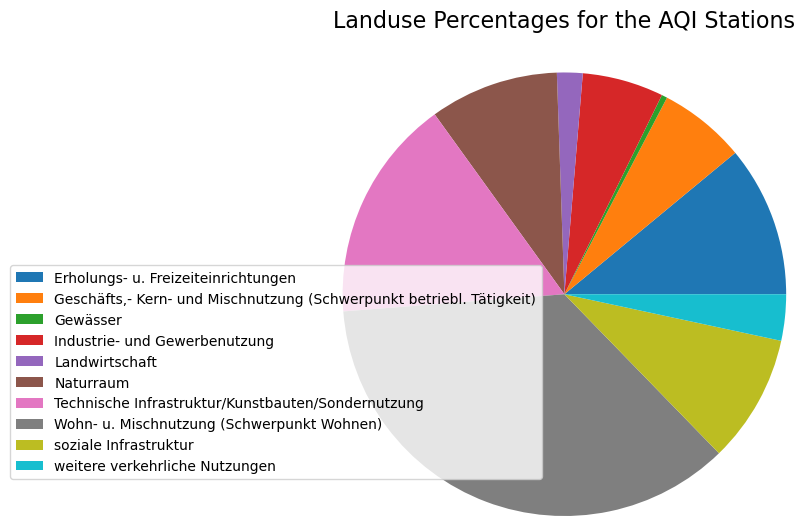

In [19]:
stats = gdf_air_rep[gdf_air_rep.columns[9:]].sum() / 15
labs = stats.index
vals = stats.values

fig, ax = plt.subplots(1)
labs = stats.index
patches, texts = plt.pie(stats.values, radius=1.5)
plt.legend(patches, labs, loc=(-1,0))
ax.set_title("Landuse Percentages for the AQI Stations", y=1.2, size=16)

In [20]:
print("Sum: ", round(gdf_air_rep[gdf_air_rep.columns[9:]].sum().sum(), 2))
gdf_air_rep[gdf_air_rep.columns[9:]].sum().round(2)

Sum:  10.46


Erholungs- u. Freizeiteinrichtungen                                     1.15
Geschäfts,- Kern- und Mischnutzung (Schwerpunkt betriebl. Tätigkeit)    0.66
Gewässer                                                                0.04
Industrie- und Gewerbenutzung                                           0.62
Landwirtschaft                                                          0.20
Naturraum                                                               0.98
Technische Infrastruktur/Kunstbauten/Sondernutzung                      1.70
Wohn- u. Mischnutzung (Schwerpunkt Wohnen)                              3.77
soziale Infrastruktur                                                   0.98
weitere verkehrliche Nutzungen                                          0.35
dtype: float64

In Vicinity to the Stations, the land use classes are more evenly distributed which is good for training the model. The total sum of percentages is only 10.46 instead of 15 (for 15 Stations) since some stations are outside of vienna and we removed one landuse class from the dataset.

# Weather Data
First, we have to review the metadata. Which weather parameters are available for us? For that we send a request to the [zamg](https://www.zamg.ac.at/cms/de/aktuell) API and review the values (unfortunately only in german). In order to avoid API changes, the request is saved and loaded for future runs of this notebook.

In [21]:
# get metadata
# or load below
# metadata = requests.get("https://dataset.api.hub.zamg.ac.at/v1/station/historical/klima-v1-1d/metadata").json()
# with open("../data/metadata_weather.pkl", "wb") as fp:
#     pickle.dump(metadata, fp)

In [22]:
with open("../data/metadata_weather.pkl", "rb") as fp:
    metadata = pickle.load(fp)

Reviewing the metadata object and the descriptions for each value, the following values are chosen for further analysis. These are concated for the API request of the weather data.

In [23]:
# chose relevant stats - unfortunately only in german :|
chosen = ['bewmit','dampfmit', 'druckmit', 'neuschnee', 'nied', 'rel', 'rel_b', 'sonne', \
          'strahl', 't', 'tmax', 'tmin', 'vv']

for param in metadata['parameters']:
    if param['name'] in chosen:
        print("{:<15} {}".format(param['name']+":", param['long_name']))

bewmit:         Bewölkungsmenge Tagesmittel der Beobachtungstermine I,II,III
dampfmit:       Dampfdruck Tagesmittel
druckmit:       Luftdruck Tagesmittel
neuschnee:      Neuschneehöhe zum Beobachtungstermin I
nied:           Niederschlagssumme
rel:            Relative Feuchte Tagesmittel
rel_b:          Relative Feuchte berechnet Tagesmittel
sonne:          Sonnenscheindauer 24h-Summe
strahl:         Globalstrahlung 24h-Summe
t:              Lufttemperaturmittel 2m
tmax:           Lufttemperatur 2m Maximum
tmin:           Lufttemperatur 2m Minimum
vv:             Windgeschwindigkeit Tagesmittel


In [24]:
# set params for API request
params = ''
for s in chosen:
    params += s + ','
    
params[:-1]

'bewmit,dampfmit,druckmit,neuschnee,nied,rel,rel_b,sonne,strahl,t,tmax,tmin,vv'

### Clip Stations
Only climate stations inside the vienna bounding box are extracted, since the metadate contains lots of stations in Austria. The ids of these stations are then also concated for the API request. 

In [25]:
# create bbox polygon
bbox = vienna.total_bounds
bbox_polygon = Polygon([(bbox[0], bbox[1]), (bbox[0], bbox[3]), (bbox[2], bbox[3]), (bbox[2], bbox[1]), (bbox[0], bbox[1])])

In [26]:
# extract station data from metadata
stations = pd.DataFrame(metadata['stations'])
stations_gdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.lon, stations.lat))
stations_clipped = gpd.clip(stations_gdf, bbox_polygon)

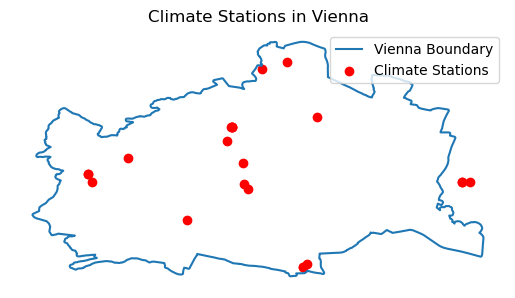

In [27]:
fig, ax = plt.subplots(1)
vienna.boundary.plot(ax=ax)
stations_clipped.plot(ax=ax, color='red')
ax.legend(['Vienna Boundary', 'Climate Stations'])
ax.axis('off')
_ = ax.set_title('Climate Stations in Vienna')

Different CRS, so Vienna looks more wide.

In [28]:
# set ids for API request
ids = ''
for s in stations_clipped.id.values.tolist():
    ids += s + ','
    
ids[:-1]

'4120,5802,5804,5805,5808,5904,5905,5917,5970,4115,5901,5902,5916,5925,5963,5965,5972,5935,31,105,106,107'

### Request weather data via API
The weather data is requested form the daily (since AQI data is also daily) historical [zamg](https://www.zamg.ac.at/cms/de/aktuell) API and is then saved as a pickle dump to avoid future complications. The timestamps are also extracted for attaching the values later to the AQI values. 

The stations are put in a GeoDataFrame that is als reprojected to EPSG:32633. Also if more than four of the weather variables don't contain values the station is dropped. This is because we need all independet variables for each observation for our train data.

In [29]:
# Create and send request
# req = f"https://dataset.api.hub.zamg.ac.at/v1/station/historical/klima-v1-1d?parameters={params[:-1]}&start={start_date}T08:00&end={end_date}T09:00&station_ids={ids[:-1]}"
# climate_data = requests.get(req).json()

# with open("../data/full_data_weather.pkl", "wb") as fp:
#     pickle.dump(climate_data, fp)

In [30]:
with open("../data/full_data_weather.pkl", "rb") as fp:
    climate_data = pickle.load(fp)
    
timestamps_climate = [x[:10] for x in climate_data['timestamps']]

In [31]:
# extract coordinates form response and put into a pandas dataframe
df_climate = pd.DataFrame(climate_data['features'])
df_climate["lon"] = df_climate.geometry.apply(lambda x: x['coordinates'][0])
df_climate["lat"] = df_climate.geometry.apply(lambda x: x['coordinates'][1])
gdf_climate = gpd.GeoDataFrame(df_climate, geometry=gpd.points_from_xy(df_climate.lon, df_climate.lat), crs=4326)
gdf_climate_rep = gdf_climate.to_crs(32633)
before_len = len(gdf_climate_rep)

In [32]:
useless = []
def remove_useless(x):
    dic = x.properties
    
    count_useless = 0
    for param in chosen:
        vals = dic['parameters'][param]['data']
        
        
        if all(value is None for value in vals):
            count_useless += 1

    
    
    if count_useless >= 4:
        useless.append(x.name)

        
_ = gdf_climate_rep.apply(remove_useless, axis=1)

gdf_climate_rep = gdf_climate_rep.drop(index=useless).reset_index()
after_len = len(gdf_climate_rep)

print(f"{before_len-after_len} of {before_len} Stations were discarded!")

10 of 22 Stations were discarded!


### Get Dict with closest Climate Station to each Air Quality Station - Nearest Neighbor Interplation
For relating the weather data the AQI stations the nearest neighbor interpolation is used. For each AQI station the closest weather station is computed and saved in a relation dict. Then the climate data is attached to the AQI GeoDataFrame.

In [33]:
air_to_climate = {}

def get_closest_climate(air_station):
    air_id = air_station.name
    p = nearest_points(air_station.geometry, gdf_climate_rep.geometry.unary_union)[1]            
    p2 = gdf_climate_rep[gdf_climate_rep.geometry == p].index.values[0]
    air_to_climate[air_id] = p2

_ = gdf_air_rep.apply(get_closest_climate, axis=1)

In [34]:
clim_data = []

for air, clim in air_to_climate.items():
    clim_data.append(gdf_climate_rep.loc[clim].properties)
    
gdf_air_rep['climate_data'] = clim_data

### Combine Weather and AQI Data
Since the GeoDataFrame contains a column of dataframes containing the AQI data for each station we attach the weather data inside each of these dataframes for the respective dates. This has to be done for each weather parameter and each station.

In [35]:
def combine_weather_aqi(row, vienna=True):
    for param in chosen:            
        vals = row['climate_data']['parameters'][param]['data']
        for i, val in enumerate(vals):
            date = timestamps_climate[i]
            
            if vienna:
                gdf_air_rep.loc[row.name, 'data'].loc[date, param] = val
            else: 
                gdf_air_graz_rep.loc[row.name, 'data'].loc[date, param] = val

_ = gdf_air_rep.apply(combine_weather_aqi, axis=1, vienna=True)

### Create Training Samples
After that, each day of measurements is enhanced with the landuse data from the respective station and saved in the final list all_samples. This list contains all temporal and spatial observations that are then finally used for the model.

In [36]:
all_samples = []

def create_samples(row):
    # rows 1 - 10: landuses
    samples = row[9:-1].values.tolist()
    
    def export_samples(rows_data):
        export = samples + rows_data['bewmit':].values.tolist() + [rows_data[4]]
        all_samples.append(export)
        
    row.data.apply(export_samples, axis=1)
    
_ = gdf_air_rep.apply(create_samples, axis=1)


In [37]:
pd.DataFrame(all_samples).head()


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.091885,0.0,0.0,0.153341,0.0,0.053321,0.172803,0.277783,0.099212,0.0,...,0.0,72.0,NaN,0.2,589.0,15.5,18.2,12.8,2.1,50.0
1,0.091885,0.0,0.0,0.153341,0.0,0.053321,0.172803,0.277783,0.099212,0.0,...,0.7,74.0,NaN,1.6,587.0,15.4,17.3,13.4,3.2,10.0
2,0.091885,0.0,0.0,0.153341,0.0,0.053321,0.172803,0.277783,0.099212,0.0,...,0.0,64.0,NaN,6.5,1225.0,14.5,17.3,11.7,3.8,13.0
3,0.091885,0.0,0.0,0.153341,0.0,0.053321,0.172803,0.277783,0.099212,0.0,...,-1.0,70.0,NaN,2.5,784.0,14.7,18.3,11.0,2.1,29.0
4,0.091885,0.0,0.0,0.153341,0.0,0.053321,0.172803,0.277783,0.099212,0.0,...,-1.0,75.0,NaN,6.1,1113.0,12.4,19.6,5.1,1.5,48.0


# Prepare Data for Regression
The respective names for the variables are extracted. It is analysed which variables have lots of nodata values, these are removed, since we need all independent variables for each observation and do not want to remove all these observations. After that, all nodata values are dropped from the table.

In [38]:
idx_keys = gdf_air_rep.columns[9:-1].values.tolist() + gdf_air_rep['data'].loc[0].loc['2022-10-01'].keys().tolist()[5:] + ['aqi']

In [39]:
arr = np.array(all_samples)
df = pd.DataFrame(arr)
df.columns = idx_keys
df = df.loc[df['aqi'].dropna().index]

In [40]:
df.apply(lambda x: x.isna().sum())

Erholungs- u. Freizeiteinrichtungen                                        0
Geschäfts,- Kern- und Mischnutzung (Schwerpunkt betriebl. Tätigkeit)       0
Gewässer                                                                   0
Industrie- und Gewerbenutzung                                              0
Landwirtschaft                                                             0
Naturraum                                                                  0
Technische Infrastruktur/Kunstbauten/Sondernutzung                         0
Wohn- u. Mischnutzung (Schwerpunkt Wohnen)                                 0
soziale Infrastruktur                                                      0
weitere verkehrliche Nutzungen                                             0
bewmit                                                                  1863
dampfmit                                                                   5
druckmit                                                                   5

In [41]:
drops = ["bewmit", "neuschnee", "rel_b"]
df = df.drop(columns=drops)
df = df.dropna()

# Exploration of Pre-Regression Variables
Now the cleaned variables are explored.

In [42]:
exploration = copy.deepcopy(gdf_air_rep)

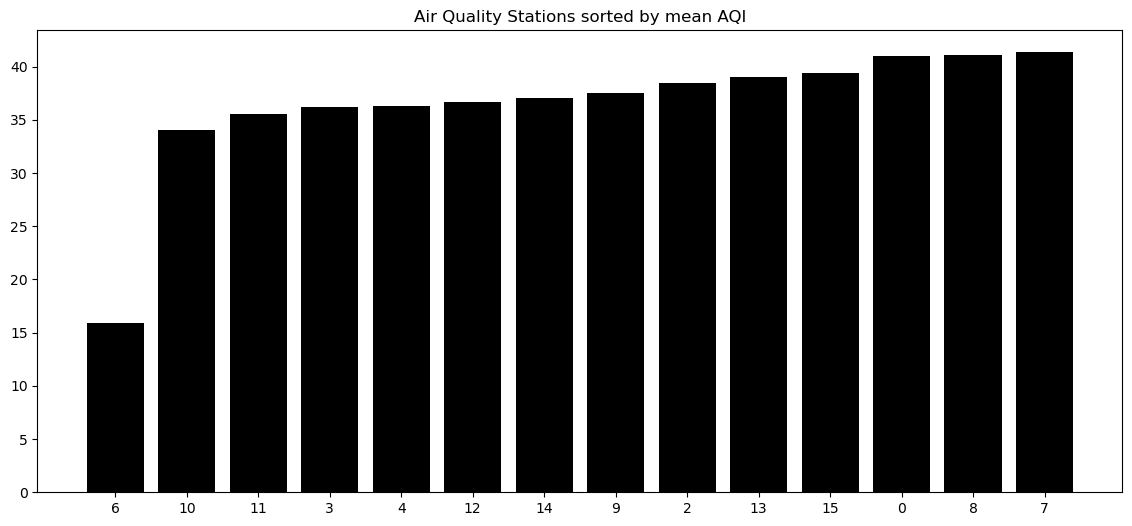

In [43]:
means = exploration.apply(lambda x: x['data']['AQI'].mean(), axis=1)
exploration['means'] = means
fig, ax = plt.subplots(1, figsize=(14, 6))
ax.set_title("Air Quality Stations sorted by mean AQI")
ax = plt.bar([str(x) for x in means.dropna().sort_values().index], means.dropna().sort_values().values, color='black')

We can see, that one of our stations has significantly lower AQI values (e.g. better quality). The other stations are more or less in the same range of values. Some of the stations do not have AQI values for our weather data period and thus have to be dropped.

(586311.5875335498, 618886.5224549124, 5329103.037580323, 5354398.106086125)

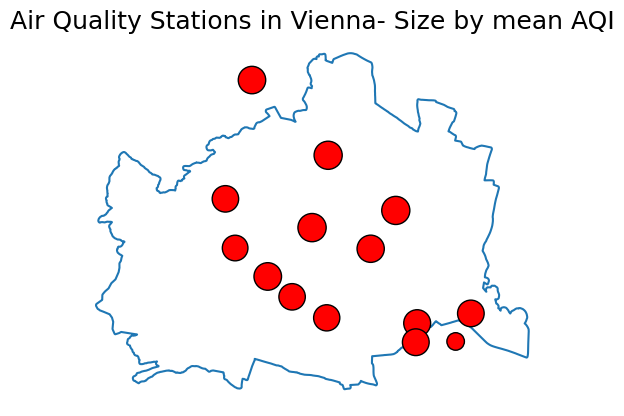

In [44]:
fig, ax = plt.subplots(1)
vienna_rep.boundary.plot(ax=ax)
_ = ax.set_title('Air Quality Stations in Vienna- Size by mean AQI', size=18)
exploration.plot(ax=ax, color="red", markersize=exploration['means']*10, edgecolor='black', zorder=1000)
ax.axis('off')

The station with the significantly lower AQI is located south east of the boundary of viennas administrative boundaries. It could be that this station is located away from streets or that some other variables influence the air quality here.

In [45]:
df_no_aqi = df.drop(columns='aqi')
cols = df_no_aqi.columns.tolist()

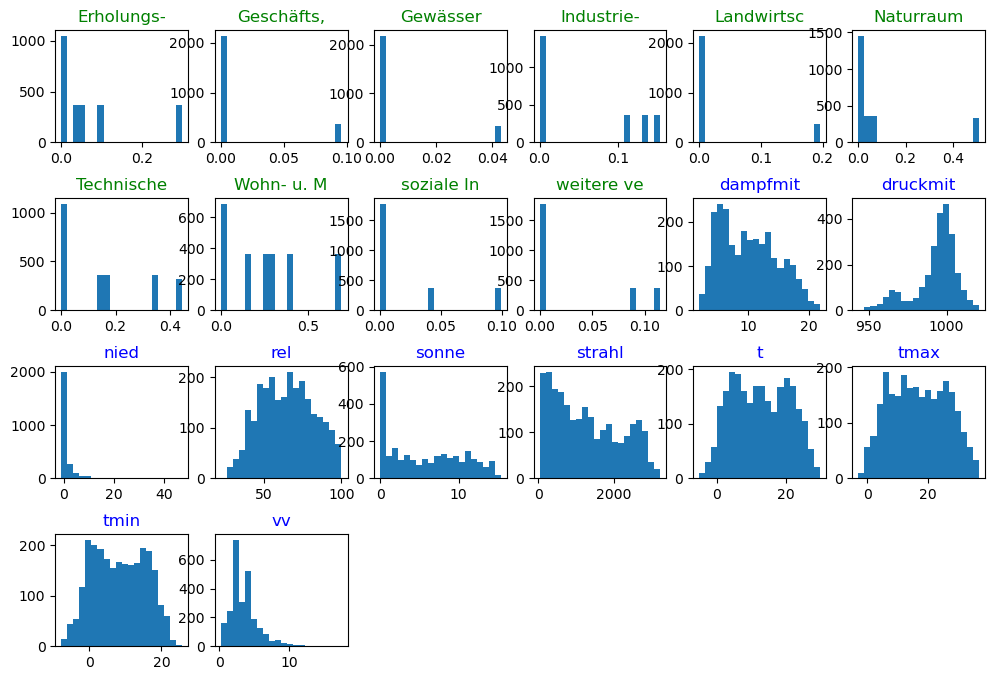

In [46]:
fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(12, 8), gridspec_kw={'hspace': 0.5})
k = 0
for i in range(4):
    for j in range(6):
        if k == 20:
            axs[i, j].axis('off')
            continue
        axs[i, j].hist(df_no_aqi[cols[k]], bins=20)
        if k <= 9:
            axs[i, j].set_title(cols[k][:10], color='green')
        else:
            axs[i, j].set_title(cols[k][:10], color='blue')
        k += 1

This plot shows histograms for each variable. The data seemms to be in order.

Since the Landuse variables only change for the different stations and not over time, there are less bins in the histogram to be filled. However we still see a healthy distribution vor most of the variables. Landwirtschaft (Agriculture) or Gewässer (Waterbodies) only have values for very few stations. However this was expected, since by its nature, landuse zones are not evenly distributed over space. Some other variables e.g. "Technische Infrastruktur/Kunstbauten/Sondernutzung" (technical infrastructure/...) or "Wohn- u. Mischnutzung (Schwerpunkt Wohnen)" (Residential/Mixed - mainly residential) have good distributions over the dataset.

Also the weather variables show the expected distributions.

In [47]:
df.describe()

,Erholungs- u. Freizeiteinrichtungen,"Geschäfts,- Kern- und Mischnutzung (Schwerpunkt betriebl. Tätigkeit)",Gewässer,Industrie- und Gewerbenutzung,Landwirtschaft,Naturraum,Technische Infrastruktur/Kunstbauten/Sondernutzung,Wohn- u. Mischnutzung (Schwerpunkt Wohnen),soziale Infrastruktur,weitere verkehrliche Nutzungen,...,druckmit,nied,rel,sonne,strahl,t,tmax,tmin,vv,aqi
count,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,...,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000
mean,0.069116,0.013880,0.005589,0.058187,0.028373,0.077863,0.153456,0.257029,0.020164,0.029257,...,993.085486,0.734649,64.760367,5.769338,1280.094498,12.679984,16.945813,8.366348,3.573445,37.200598
std,0.099886,0.033692,0.014488,0.067290,0.068874,0.168465,0.163029,0.221132,0.035376,0.046363,...,13.922316,3.700594,17.355627,4.676047,882.856386,8.087907,9.382327,7.169857,2.025747,24.766587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,943.300000,-1.000000,22.000000,0.000000,38.000000,-5.200000,-3.000000,-7.700000,0.200000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,988.875000,-1.000000,51.000000,1.275000,493.750000,5.700000,9.200000,2.200000,2.100000,17.000000
50%,0.037743,0.000000,0.000000,0.000000,0.000000,0.000000,0.143830,0.244019,0.000000,0.000000,...,996.600000,-1.000000,65.000000,5.400000,1148.500000,12.400000,16.800000,8.300000,3.200000,31.000000
75%,0.091885,0.000000,0.000000,0.137094,0.000000,0.053321,0.343140,0.390944,0.039720,0.086924,...,1001.800000,0.800000,78.000000,9.900000,2011.000000,19.800000,24.900000,14.700000,4.500000,55.000000
max,0.299195,0.095632,0.043129,0.153341,0.195494,0.511611,0.445260,0.688111,0.099212,0.114658,...,1021.000000,47.100000,100.000000,15.400000,3229.000000,29.900000,37.000000,25.700000,17.500000,146.000000


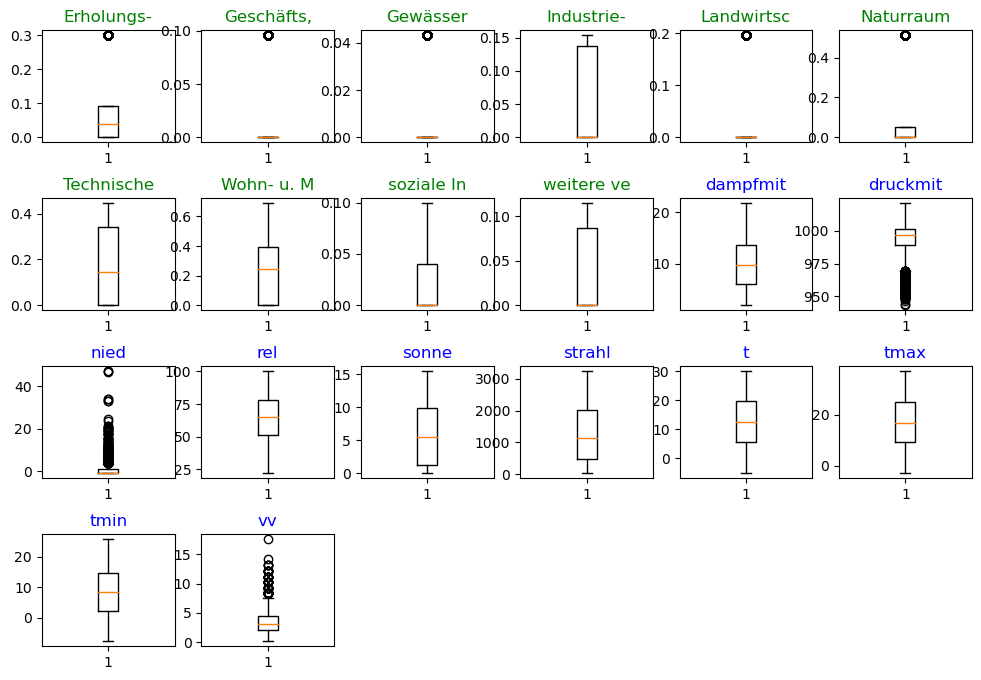

In [48]:
cols = df.columns.tolist()
fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(12, 8), gridspec_kw={'hspace': 0.5})
k = 0
for i in range(4):
    for j in range(6):
        if k == 20:
            axs[i, j].axis('off'); continue
        axs[i, j].boxplot(df[cols[k]])
        if k <= 9:
            axs[i, j].set_title(cols[k][:10], color='green')
        else:
            axs[i, j].set_title(cols[k][:10], color='blue')
        k += 1

For the Weather variables the data distribution is more classic, except vor example nied (percipitation) or vv (wind speed). The landuse variables are less well distributed.

# Regression

## Describe and Justify Methods
The Air Quality Model is a classic Regression task. For building the regression model a linear and Random Forest model as created. 

The linear model is straight foreward.
Fit intercept has to be true, since our data is not centered. X has to be copied, since we want to use the same data again later. n_jobs can stay one, since our data is not too big.

For the Random Forest Model we use 250 estimators (a good balance between accuracy and runtime). The mean absolute error is used, since outliers can happen in this dataset and should not weigh to much for the model. Bootstrapping is used, since it give it makes the model a lot better.

In [49]:
xtrain = df.drop(columns='aqi').values
ytrain = df['aqi'].values

xtrain, xtest, ytrain, ytest = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)

lm = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=1)
lm.fit(xtrain, ytrain)

rf = RandomForestRegressor(n_estimators=250, criterion="absolute_error", max_depth=None, max_features="auto", \
                           bootstrap=True, min_samples_split=2, n_jobs=1)

rf.fit(xtrain, ytrain)

RandomForestRegressor(criterion='absolute_error', n_estimators=250, n_jobs=1)

## Results and Interpretation of Model

Text(0, 0.5, 'Test')

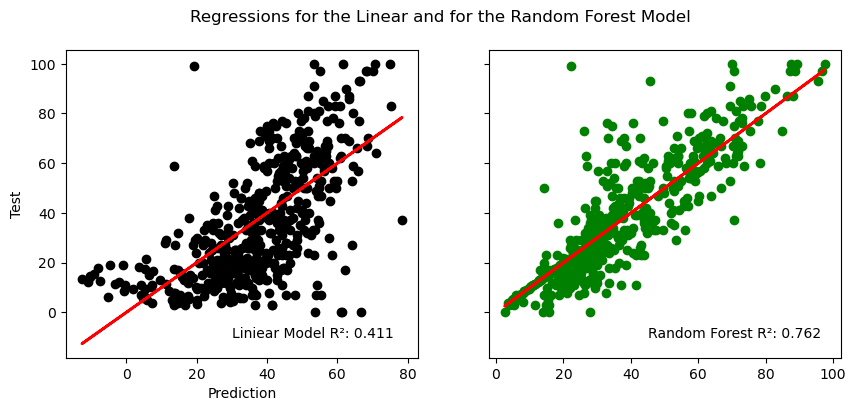

In [50]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=True); fig.suptitle('Regressions for the Linear and for the Random Forest Model')
ypred = lm.predict(xtest)
axs[0].plot(ypred, ytest, "o", color='black')
axs[0].plot(ypred, ypred, "r-", linewidth=2)
axs[0].text(30, -10, s="Liniear Model R²: " + str(round(r2_score(ytest, ypred), 3)))
axs[0].set_xlabel('Prediction'); axs[0].set_ylabel('Test')

ypred = rf.predict(xtest)
axs[1].plot(ypred, ytest, "o", color='green')
axs[1].plot(ypred, ypred, "r-", linewidth=2)
axs[1].text(45, -10, s="Random Forest R²: "+ str(round(r2_score(ytest, ypred), 3)), backgroundcolor='white')
axs[0].set_xlabel('Prediction'); axs[0].set_ylabel('Test')

### Feature Importances

In [51]:
tup = {}
for lab, fi in zip(df.columns[:-1], rf.feature_importances_):
    tup[lab[:20]] =  round(fi, 4)
    
tsort = dict(sorted(tup.items(), key=lambda item: item[1], reverse=True))

for key, val in tsort.items():
    print("{:<25} {} ".format(key, val))

dampfmit                  0.121 
sonne                     0.1183 
Wohn- u. Mischnutzun      0.1172 
strahl                    0.1144 
rel                       0.0806 
vv                        0.0664 
tmin                      0.0641 
druckmit                  0.061 
t                         0.0534 
tmax                      0.0507 
Technische Infrastru      0.043 
nied                      0.0394 
Gewässer                  0.0253 
Naturraum                 0.022 
Erholungs- u. Freize      0.0071 
Industrie- und Gewer      0.0055 
soziale Infrastruktu      0.0035 
weitere verkehrliche      0.0034 
Geschäfts,- Kern- un      0.0022 
Landwirtschaft            0.0015 


The feature importances of the Random Forest model also give interesting insights in the variables. Generally the weather variables have more importance than the landuse ones. sonne (sunshine) has (most of the time) the heighest feature importance, as well as strahl (global radiation) dampfmit (mean vapor pressure). For the landuse variables Wohn- u. Misch... (residential and mixed used) has by far the highest feature importance. All other classes have lower importances than the weather variables. 

# Test model under different Circumstances: GRAZ
The code below is a litte ugly, but basically what happens is that codes from before are recycled in order to infer the dependent and independet variables for the AQI stations in Graz. The landuse is taken from OSM in this case, the landuse classes are changed, to correspond to the ones in the original dataset.

In [52]:
graz = gpd.read_file("../data/graz.shp")
graz_rep = graz.to_crs(32633)

bounds_graz = graz.bounds.values[0].tolist()
st_graz = str(bounds_graz[1]) + ',' + str(bounds_graz[0]) + ',' + str(bounds_graz[3]) + ',' + str(bounds_graz[2])

# req_graz = f"https://api.waqi.info/v2/map/bounds?latlng={st_graz}&networks=all&token={token}"
# response_air_graz = requests.get(req_graz).json()

# with open("../data/response_air_graz.pkl", "wb") as fp:
#     pickle.dump(response_air_graz, fp)

with open("../data/response_air_graz.pkl", "rb") as fp:
    response_air_graz = pickle.load(fp)

df_air_graz = pd.DataFrame(response_air_graz['data'])
df_air_graz['name'] = df_air_graz.station.apply(lambda x: x['name']).values.tolist()
df_air_graz = df_air_graz.rename(columns={'aqi': 'current_response_aqi'})

gdf_air_graz = gpd.GeoDataFrame(df_air_graz, geometry=gpd.points_from_xy(df_air_graz.lon, df_air_graz.lat), crs=4326)

# Load in and use first 10 letters to identify station
csvs = sorted(os.listdir('../data/airquality_graz'))
airquality_csvs = {}
for csv in csvs:
    df_temp = pd.read_csv(f'../data/airquality_graz/{csv}')

    df_temp['date'] = pd.to_datetime(df_temp.date)
    df_temp = df_temp.set_index('date')
    df_temp = df_temp.loc[start_date:end_date]
    df_temp = df_temp.apply(lambda x: x.astype(float))
   

    # Take the maximum (like said on website)
    df_temp['AQI'] = df_temp.max(axis=1)
    
    
    airquality_csvs[csv[:10].replace(" ", "-")] = df_temp

# Use first 10 letters for the air quality metadata as well
gdf_air_graz['name10'] = gdf_air_graz['name'].apply(lambda x: x[:10].lower().replace(" ", "-"))
gdf_air_graz = gdf_air_graz.sort_values('name10').reset_index().drop(columns=['index'])
gdf_air_graz['data'] = airquality_csvs.values()

def set_index(df_graz):
    df_graz.index = df_graz.index.astype(str)
    return df_graz

gdf_air_graz['data'] = gdf_air_graz['data'].apply(set_index)

gdf_air_graz_rep = gdf_air_graz.to_crs(32633)

classes_landuse_graz = []
mapping = [3, 0, 7, 5, 9, 0, 5, 4, 3, 4, 4, 5, 6, 9, 4, 1, 9, 3, 1, 8, 5, 4, 3, 4, 4, 3, 2, 8, 0, 4, 1, 3, 0, 9]

landuse_diss_rep_graz = gpd.read_file("../data/landuse_graz_diss_repr_fixed.shp")
landuse_diss_rep_graz = landuse_diss_rep_graz.drop(index=landuse_diss_rep_graz[landuse_diss_rep_graz.landuse=='fixme'].index)
landuse_og = copy.deepcopy(landuse_diss_rep)


for i in range(len(landuse_diss_rep_graz.landuse.values.tolist())):
    classes_landuse_graz.append(classes_landuse[mapping[i]])

landuse_diss_rep_graz['NUTZUNG_L0'] = classes_landuse_graz

landuse_diss_rep_graz = landuse_diss_rep_graz.dissolve(by='NUTZUNG_L0').reset_index()

stations_percentages = {}

# These have to be named that way in order for the function below to work
classes_landuse =  classes_landuse_graz
landuse_diss_rep = landuse_diss_rep_graz

_ = gdf_air_graz_rep.apply(clipping, axis=1)

perc = pd.DataFrame(stations_percentages).T.fillna(0)

gdf_air_graz_rep[perc.columns] = perc

# create bbox polygon
bbox = graz.total_bounds
bbox_polygon_graz = Polygon([(bbox[0], bbox[1]), (bbox[0], bbox[3]), (bbox[2], bbox[3]), (bbox[2], bbox[1]), (bbox[0], bbox[1])])

# extract station data from metadata
# stations = pd.DataFrame(metadata['stations'])
# stations_gdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.lon, stations.lat))
stations_clipped = gpd.clip(stations_gdf, bbox_polygon_graz)

# set ids for API request
ids = ''
for s in stations_clipped.id.values.tolist():
    ids += s + ','

# Create and send request
# req = f"https://dataset.api.hub.zamg.ac.at/v1/station/historical/klima-v1-1d?parameters={params[:-1]}&start={start_date}T08:00&end={end_date}T09:00&station_ids={ids[:-1]}"
# climate_data_graz = requests.get(req).json()

# with open("../data/full_data_weather_graz.pkl", "wb") as fp:
#     pickle.dump(climate_data_graz, fp)

with open("../data/full_data_weather_graz.pkl", "rb") as fp:
    climate_data_graz = pickle.load(fp)
    
timestamps_climate = [x[:10] for x in climate_data_graz['timestamps']]

# extract coordinates form response and put into a pandas dataframe
df_climate_graz = pd.DataFrame(climate_data_graz['features'])
df_climate_graz["lon"] = df_climate_graz.geometry.apply(lambda x: x['coordinates'][0])
df_climate_graz["lat"] = df_climate_graz.geometry.apply(lambda x: x['coordinates'][1])
gdf_climate_graz = gpd.GeoDataFrame(df_climate_graz, geometry=gpd.points_from_xy(df_climate_graz.lon, df_climate_graz.lat), crs=4326)
gdf_climate_graz_rep = gdf_climate_graz.to_crs(32633)

useless = []        
_ = gdf_climate_graz_rep.apply(remove_useless, axis=1)

gdf_climate_graz_rep = gdf_climate_graz_rep.drop(index=useless).reset_index()

air_to_climate = {}
_ = gdf_air_graz_rep.apply(get_closest_climate, axis=1)

clim_data = []
for air, clim in air_to_climate.items():
    clim_data.append(gdf_climate_graz_rep.loc[clim].properties)
    
gdf_air_graz_rep['climate_data'] = clim_data

_ = gdf_air_graz_rep.apply(combine_weather_aqi, axis=1, vienna=False)

all_samples = []

def create_samples(row):
    # rows 1 - 10: landuses
    samples = row[9:-1].values.tolist()
    
    def export_samples(rows_data):
        #print(rows_data)
        
        #print(str(len(rows_data['bewmit':].values.tolist()))+"AAAAAAA")
        #print(rows_data['bewmit':])
        
            
        export = samples + rows_data['bewmit':].values.tolist() + [rows_data[4]]

        
        all_samples.append(export)
        
    row.data.apply(export_samples, axis=1)
    
_ = gdf_air_graz_rep.apply(create_samples, axis=1)

m1_graz = np.array(all_samples)
df_graz = pd.DataFrame(m1_graz)

df_graz.columns = idx_keys
df_graz = df_graz.loc[df_graz['aqi'].dropna().index]

drops = ["bewmit", "neuschnee", "rel_b"]
df_graz = df_graz.drop(columns=drops)
df_graz = df_graz.dropna()

# Results Model Graz

In [53]:
xtest_graz = df_graz.drop(columns='aqi').values
ytest_graz = df_graz['aqi'].values

In [54]:
ypred_graz = rf.predict(xtest_graz)
r2_score(ytest_graz, ypred_graz)

-11.62701766834305

Unfortunately, the model does not seem to work for Graz. This could have multiple reasons. These could simply be the size or topography of Graz or other variables not used in the analysis. Or the landuse classes in OSM are of bad quality. However analysing this further is beyond the scope of this analysis.

# Results: Predict Raster for Vienna
Take the bounds of vienna and make a grid. In order to get a nice looking hexagonal grid with hexagons of 250 Meters in each direction, we need to put a point every 250 meters in y direction with an offset of 750/2 meters every second row and every 750 meters in x direction. For each of these points, again, the landuse percentages are calculated. This is done again for a 100 meter buffer, NOT for the whole hexagon, since that would be too big of an influence area and would not be consistent with the training data.

Finally, the points are clipped to viennas geometry.

In [55]:
min_x, min_y, max_x, max_y = vienna_rep.total_bounds[0], vienna_rep.total_bounds[1], vienna_rep.total_bounds[2], vienna_rep.total_bounds[3]

point_spacing_x = 750  # meters
point_spacing_y = 250

num_points_x = int((max_x - min_x) / point_spacing_x)
num_points_y = int((max_y - min_y) / point_spacing_y)

points = []
for i in range(num_points_x):
    for j in range(num_points_y):
        
        if j % 2 == 0:
            const = 0
        else:
            const = 750/2
       
        x = min_x + i * point_spacing_x + const
        y = min_y + j * point_spacing_y
        points.append((x, y))

        
points_df = pd.DataFrame(columns=df.columns)
points_df[['x', 'y']] = pd.DataFrame(points)
points_df['geometry'] = gpd.points_from_xy(points_df['x'], points_df['y'])
points_gdf = gpd.GeoDataFrame(points_df, geometry='geometry', crs=32633)
points_gdf = gpd.clip(points_gdf, vienna_rep)
points_gdf = points_gdf.drop(columns='aqi')

idx_keys_independet = [key for key in df.columns if key in points_gdf.columns]
points_cols_new = points_gdf.columns

Here we still have the point dataframe without prediction values.

In [56]:
#points_gdf = points_gdf.sample(50)
points_gdf.head(3)

,Erholungs- u. Freizeiteinrichtungen,"Geschäfts,- Kern- und Mischnutzung (Schwerpunkt betriebl. Tätigkeit)",Gewässer,Industrie- und Gewerbenutzung,Landwirtschaft,Naturraum,Technische Infrastruktur/Kunstbauten/Sondernutzung,Wohn- u. Mischnutzung (Schwerpunkt Wohnen),soziale Infrastruktur,weitere verkehrliche Nutzungen,...,rel,sonne,strahl,t,tmax,tmin,vv,x,y,geometry
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,588167.266394,5.336003e+06,POINT (588167.266 5336002.813)
47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,588167.266394,5.342003e+06,POINT (588167.266 5342002.813)
112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,588917.266394,5.335503e+06,POINT (588917.266 5335502.813)


Apply the clipping function from above again to all the points. Since this takes a lot of time, it is only done once and then saved.

In [57]:
# stations_percentages = {}
# _ = points_gdf.apply(clipping, axis=1)
# perc = pd.DataFrame(stations_percentages).T.fillna(0)
# points_gdf[perc.columns] = perc

# new_cols = [str(x) for x in range(len(points_gdf.columns))]
# points_gdf.columns = new_cols
# points_gdf = points_gdf.rename(columns={'25': 'geometry'})

# points_gdf.to_file("../data/prediction_grid.shp")

In [58]:
points_gdf = gpd.read_file("../data/prediction_grid2.shp")
points_gdf.columns = points_cols_new

(586742.2663936117, 618092.2663936117, 5329390.313421496, 5353865.313421496)

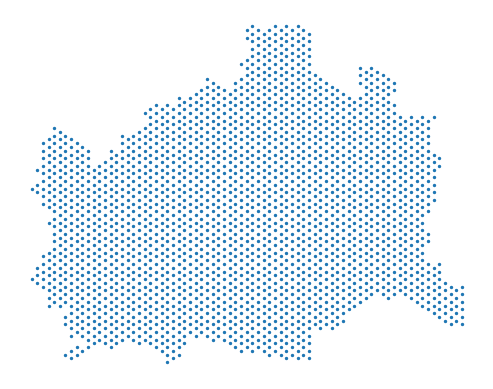

In [59]:
fig, ax = plt.subplots(1)
points_gdf.plot(ax=ax, markersize=2)
ax.axis('off')

Apply function from above to get the nearest climate stations

In [60]:
# req = f"https://dataset.api.hub.zamg.ac.at/v1/station/historical/klima-v1-1d?parameters={params[:-1]}&start={analysis_date}T00:00&end={analysis_date}T23:59&station_ids={ids[:-1]}"
# climate_values = requests.get(req).json()['features']
# with open("../data/weather_raster.pkl", "wb") as fp:
#     pickle.dump(climate_values, fp)

In [61]:
with open("../data/weather_raster.pkl", "rb") as fp:
    climate_values = pickle.load(fp)

Remove useless Stations for this timeframe again

In [62]:
climate_values_df = pd.DataFrame(climate_values)
climate_values_df["lon"] = climate_values_df.geometry.apply(lambda x: x['coordinates'][0])
climate_values_df["lat"] = climate_values_df.geometry.apply(lambda x: x['coordinates'][1])
gdf_climate_values = gpd.GeoDataFrame(climate_values_df, geometry=gpd.points_from_xy(climate_values_df.lon, climate_values_df.lat), crs=4326)
gdf_climate_values = gdf_climate_values.to_crs(32633)

useless = []
_ = gdf_climate_values.apply(remove_useless, axis=1)
gdf_climate_values = gdf_climate_values.drop(index=useless).reset_index()
gdf_climate_values['sonne'] = gdf_climate_values.properties.apply(lambda x: x['parameters']['sonne']['data'][0])

Get Climate Station

In [63]:
air_to_climate_raster = {}

def get_closest_climate2(air_station):
    air_id = air_station.name
    p = nearest_points(air_station.geometry, gdf_climate_values.geometry.unary_union)[1]            
    p2 = gdf_climate_values[gdf_climate_values.geometry == p].index.values[0]
    air_to_climate_raster[air_id] = p2
    
_ = points_gdf.apply(get_closest_climate2, axis=1)

Add current climate Values

In [64]:
def current_climate_values(column):
    param = column.name
    
    vals = []
    for i in range(len(column)):
        idx = points_gdf.index[i]
        weather_id = air_to_climate_raster[idx]

        vals.append(gdf_climate_values.loc[weather_id].properties['parameters'][param]['data'][0])
        
    return vals

param_columns = [p for p in chosen if p in idx_keys_independet]
points_gdf[param_columns] = points_gdf[param_columns].apply(current_climate_values)

In [65]:
points_gdf[idx_keys_independet].head(3)

,Erholungs- u. Freizeiteinrichtungen,"Geschäfts,- Kern- und Mischnutzung (Schwerpunkt betriebl. Tätigkeit)",Gewässer,Industrie- und Gewerbenutzung,Landwirtschaft,Naturraum,Technische Infrastruktur/Kunstbauten/Sondernutzung,Wohn- u. Mischnutzung (Schwerpunkt Wohnen),soziale Infrastruktur,weitere verkehrliche Nutzungen,dampfmit,druckmit,nied,rel,sonne,strahl,t,tmax,tmin,vv
0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,10.3,989.8,-1.0,62.0,10.2,2178.0,11.0,19.6,2.3,2.1
1,0.0,0.0,0.0,0.0,0.0,0.128681,0.0,0.164673,0.0,0.0,10.3,989.8,-1.0,62.0,10.2,2178.0,11.0,19.6,2.3,2.1
2,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,10.3,989.8,-1.0,62.0,10.2,2178.0,11.0,19.6,2.3,2.1


### Predict Values for Raster

In [66]:
points_gdf = points_gdf.dropna()
new_pred = points_gdf[idx_keys_independet].values

prediction_raster = rf.predict(new_pred)

points_gdf['prediction'] = prediction_raster

In [67]:
def create_hexagon(point):
    x, y = point.x, point.y

    # Calculate the coordinates of the hexagon vertices
    vertices = [
        (x - hex_size, y),
        (x - hex_size/2, y + hex_size),
        (x + hex_size/2, y + hex_size),
        (x + hex_size, y),
        (x + hex_size/2, y - hex_size),
        (x - hex_size/2, y - hex_size),
        (x - hex_size, y)
    ]    

    # Create a hexagon polygon from the vertices
    hexagon = Polygon(vertices)
    return hexagon

In [68]:
hex_size = 250
hexagons = points_gdf.geometry.apply(create_hexagon)
points_gdf['hexagons'] = hexagons
hex_gdf = gpd.GeoDataFrame(points_gdf, geometry='hexagons')

(586311.5875335498, 618886.5224549124, 5329103.037580323, 5354398.106086125)

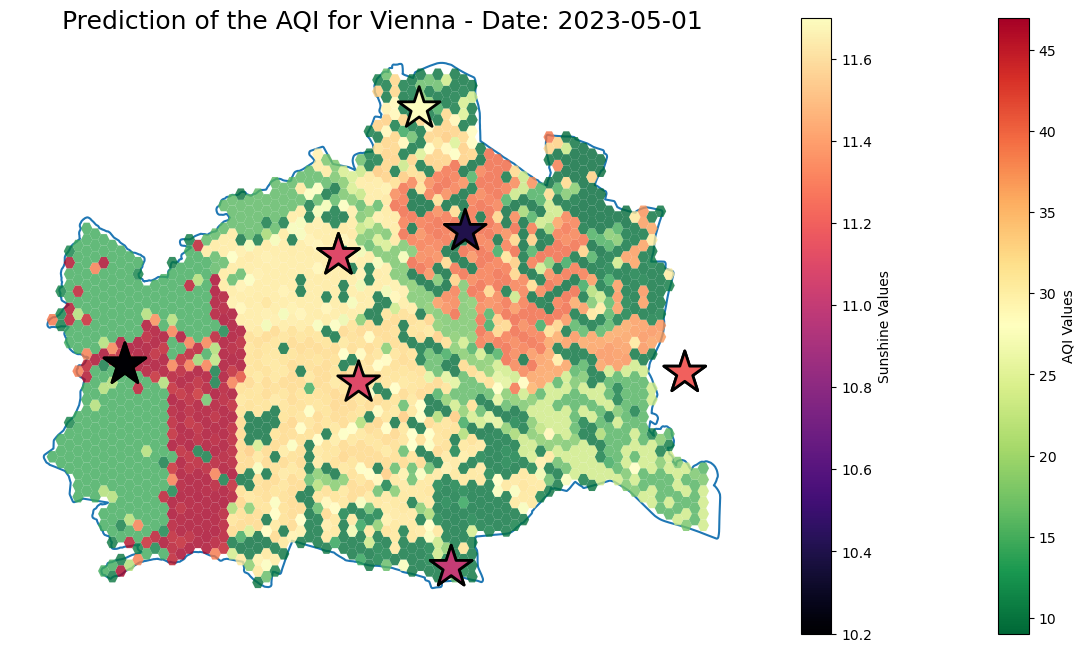

In [69]:
fig, ax = plt.subplots(nrows=1, figsize=(15, 8))
ax.set_title(f'Prediction of the AQI for Vienna - Date: {analysis_date}', size=18)
hex_gdf.plot(ax = ax, column='prediction', cmap='RdYlGn_r', zorder=1000, legend=True, alpha=0.8,\
            legend_kwds={"label": "AQI Values", "orientation": "vertical"})
vienna_rep.boundary.plot(ax=ax)
gdf_climate_values.plot(ax=ax, marker='*', column='sonne',cmap='magma', edgecolor='black', markersize=1000, zorder=100000, legend=True, \
                       legend_kwds={"label": "Sunshine Values", "orientation": "vertical"}, linewidth=2)
points = [[p.x, p.y] for p in gdf_climate_values.geometry]
vor = Voronoi(points)
voronoi_plot_2d(vor, show_vertices=False, line_colors='blue', line_width=2, ax=axs[0])
ax.axis('off')

(586393.3811682146, 618804.6838465561, 5329225.262434442, 5354275.836541537)

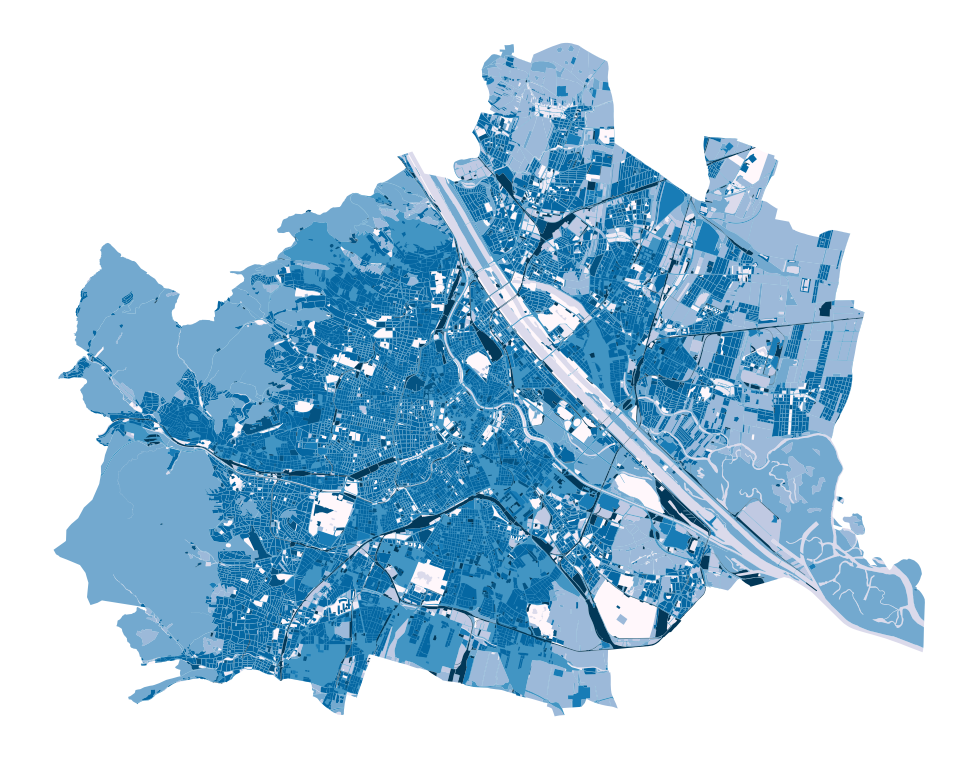

In [70]:
fig, ax = plt.subplots(nrows=1, figsize=(15, 8))
fig.tight_layout()

landuse_og.plot(column='NUTZUNG_L0', cmap='PuBu', legend=False, ax=ax, categorical=False, \
                     legend_kwds={"loc": "upper left", "bbox_to_anchor": (0, 1)})
ax.axis('off')

In [71]:
points = [[p.x, p.y] for p in gdf_climate_values.geometry]
vor = Voronoi(points)

(588891.6459097608, 618306.8376413456, 5329159.957484987, 5353255.761722477)

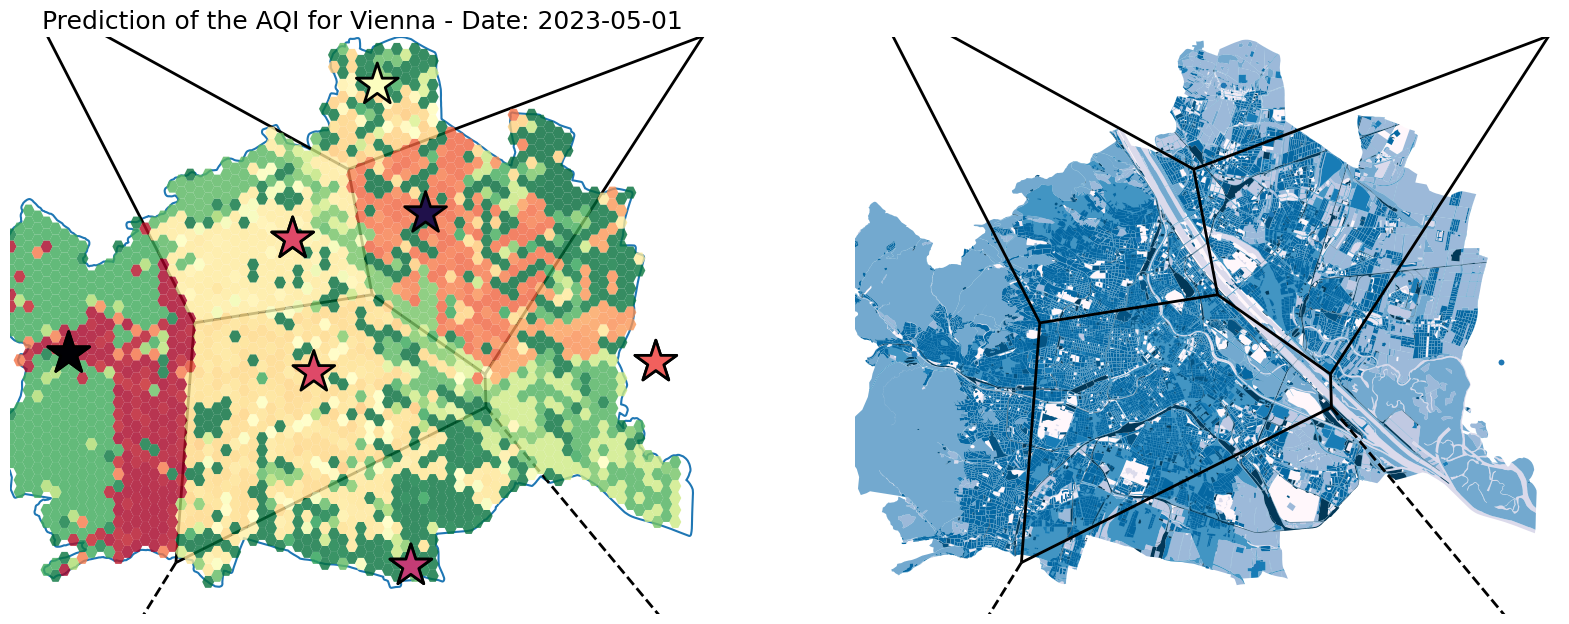

In [72]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 15))
axs[0].set_title(f'Prediction of the AQI for Vienna - Date: {analysis_date}', size=18)
hex_gdf.plot(ax = axs[0], column='prediction', cmap='RdYlGn_r', zorder=1000, legend=False, alpha=0.8, legend_kwds={"label": "AQI Values", "orientation": "horizontal"}); vienna_rep.boundary.plot(ax=axs[0])
gdf_climate_values.plot(ax=axs[0], marker='*', column='sonne',cmap='magma', edgecolor='black', markersize=1000, zorder=100000, legend=False, legend_kwds={"label": "Sunshine Values", "orientation": "horizontal"}, linewidth=2)
voronoi_plot_2d(vor, show_vertices=False, line_colors='black', line_width=2, ax=axs[0])
landuse_og.plot(column='NUTZUNG_L0', cmap='PuBu', legend=False, ax=axs[1], categorical=False, legend_kwds={"loc": "upper left", "bbox_to_anchor": (0, 1)})
voronoi_plot_2d(vor, show_vertices=False, line_colors='black', line_width=2, ax=axs[1])
axs[0].axis('off'); axs[1].axis('off')

# Only the Raster

(586311.5875335498, 618886.5224549124, 5329103.037580323, 5354398.106086125)

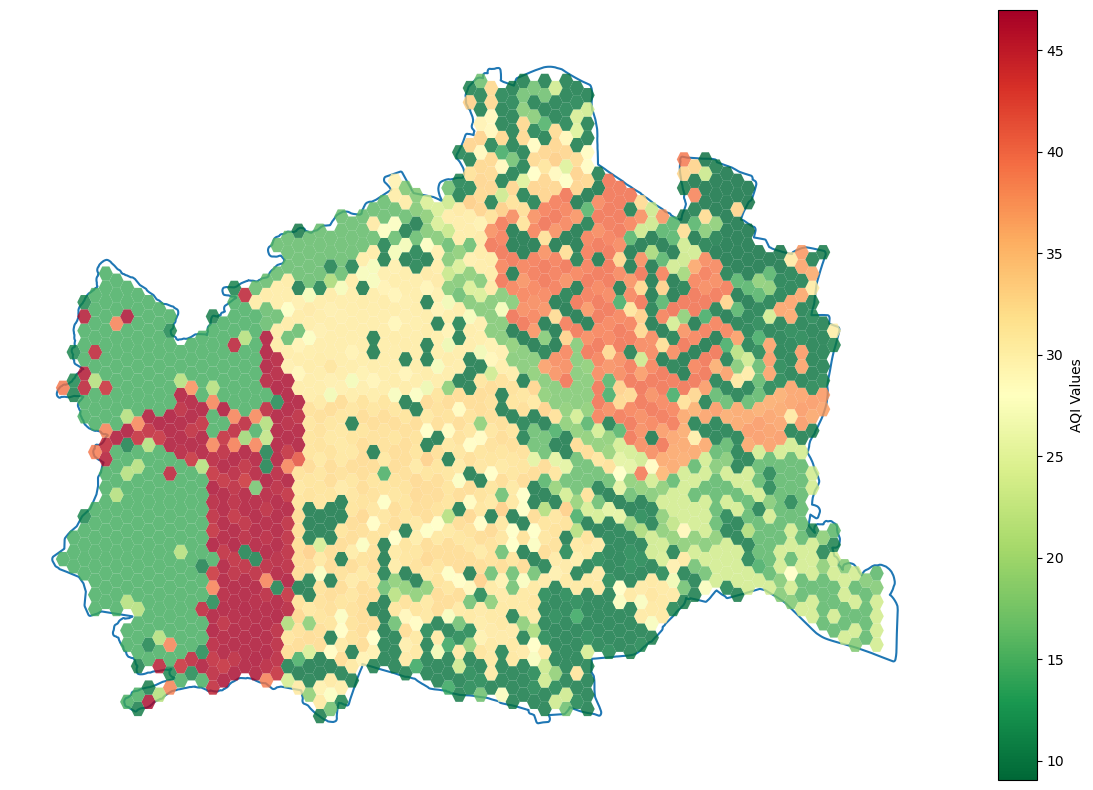

In [73]:
fig, ax = plt.subplots(nrows=1, figsize=(15, 10))
hex_gdf.plot(ax = ax, column='prediction', cmap='RdYlGn_r', zorder=1000, legend=True, alpha=0.8,\
            legend_kwds={"label": "AQI Values", "orientation": "vertical"})
vienna_rep.boundary.plot(ax=ax)
ax.axis('off')

# Answer Questions

Above we see in the first grid Map the AQI grid for Vienna with the climate stations that are colored by the sonne values (the variable with on of the heighest feature importance), the second map shows us the land classes.

Some interesting observations can be made:

Firstly, the weather data does influence the model a lot. Since nearest neighbor interpolation is used, the Voronoi regions show the borders, where another station influences the prediction region. Generally, the innner districts have a slightly worse air quality.

However, even thought the feature importances first suggested otherwise, the landuse classes also have a substential effect on the prediction, that in many cases makes a lot of sense. First, we can clearly see the difference in air quality between the Lainzer Tiergarten (a big green space in the south west of vienna with a homogenous landuse class) and the much worse quality as soon as the built up area starts, even though these areas are part of the same stations influence. Also the area of the Schloss Schönbrunn (the larger white area also in the south west) is also clearly visible in the model as an area of better quality. In the south of Vienna there is more agricultural area, that also seems to influence the model.

Generally the areas that are known to have better quality (parks, green spaces, agriculural) have better air quality than the built-up areas.

# Conclusion

Air Quality is an important topic in our rapidly urbanizing world. However, stations are often sparse. Thats why important models for predicting air quality on a wide spatial scale is important.

The infered variables for predicting air quality in Vienna produce a reliable model. This model could also be imporved by adding for example street proximity values like in the works of Kurz et al. 2014. Also better interpolation like for example inverse distance weighting or Kriging could produce better weather variables at the AQI reference stations. Also the grid ould be in a finer resolution, since the hexagons right now are bigger than the actual buffer area. This was a restriction on computing power.

Unfortunately, a refernce test with the same variables (although party from different sources) in Graz did not produce a similar good model. Some reasons for this were theorized, however a more detailed analysis on this topic.

This work was produced for the Course Geographic Predictive Analysis, Lecturer: Ass.-Prof. Dr. Ourania Kounadi, Summer Semester 2023, Master Cartography and Geoinformation.

By Simon Groß (12238274)

# References
Cioca G, Nerişanu RA. The Effects of Pandemic Restrictions on Public Health—Improvements in Urban Air Quality. International Journal of Environmental Research and Public Health. 2022; 19(15):9022. https://doi.org/10.3390/ijerph19159022.

C. Kurz, R. Orthofer, P. Sturm, A. Kaiser, U. Uhrner, R. Reifeltshammer, M. Rexeis. Projection of the air quality in Vienna between 2005 and 2020 for NO2 and PM10. Urban Climate. 2014; 10(4):703-719. https://doi.org/10.1016/j.uclim.2014.03.008.

Sunil Gulia, S.M. Shiva Nagendra, Mukesh Khare, Isha Khanna. Urban air quality management-A review. Atmospheric Pollution Research. 2015; 6 (2):286-304. https://doi.org/10.5094/APR.2015.033.

# Data Sources
AQI. Air Quality Historical Data Platform. 2023; https://aqicn.org/data-platform/register/, last accessed: 25.05.2023

Climate Data. Zentralanstalt für Meteorologie und Geodynamik. 2023; https://www.zamg.ac.at/cms/de/aktuell, last accessed: 10.05.2023 via API

Realnutzungskartierung ab 2007 Wien. 2020; https://www.data.gv.at/katalog/dataset/2f5baa1f-208c-42c2-8d04-9ea74aa1b229, last accessed: 10.05.2023

OpenStreetMap. 2023; www.openstreetmap.org, last accessed: 25.05.2023